# Cryptocurrency Prediction

Although the first redistributed cryptocurrency (bitcoin) was created in 2009, the idea of digital money arised in 1980s. In the recent years, cryptocurrencies have gained tremendeous popularity. As traditional currencies, the value of cryptocurrencies are changing in time. Using the historical data, I will implement a recurrent neural netwok using LSTM (Long short-term memory) layers to predict the trend of value of a cryptocurrency in the future.

There is a huge dataset about cryptocurrency market prices on Kaggle. 

https://www.kaggle.com/jessevent/all-crypto-currencies

I will only use a part of it which is historical price data of litecoin.

In [201]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [202]:
sns.set(style="darkgrid", font_scale=1.5)

In [203]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

After importing the libraries, we can now get the data we need:

In [204]:
df = pd.read_csv("test.csv", parse_dates=["begins_at"], index_col="begins_at")
df.shape

(2016, 8)

In [205]:
df.head()

,open_price,close_price,high_price,low_price,volume,session,interpolated,symbol
begins_at,,,,,,,,
2021-01-13 02:35:00+00:00,1022.190,1016.025,1029.625,1012.650,0,reg,False,ETHUSD
2021-01-13 02:40:00+00:00,1019.235,1021.190,1025.125,1010.650,0,reg,False,ETHUSD
2021-01-13 02:45:00+00:00,1018.110,1024.655,1031.180,1011.860,0,reg,False,ETHUSD
2021-01-13 02:50:00+00:00,1027.870,1036.235,1040.680,1021.195,0,reg,False,ETHUSD
2021-01-13 02:55:00+00:00,1033.045,1028.940,1039.560,1024.770,0,reg,False,ETHUSD


As you can see, the data includes almost 1 million rows. I just need a part of which is the "open" prince of "litecoin".

In [206]:
df = df[["open_price"]]
df.shape

(2016, 1)

In [207]:
df.head()

,open_price
begins_at,
2021-01-13 02:35:00+00:00,1022.190
2021-01-13 02:40:00+00:00,1019.235
2021-01-13 02:45:00+00:00,1018.110
2021-01-13 02:50:00+00:00,1027.870
2021-01-13 02:55:00+00:00,1033.045


We now have the historical data of litecoin from April,2013 to November,2018. Let's take a look at how it changed through time.

Text(0.5, 1.0, 'Price of ETHER')

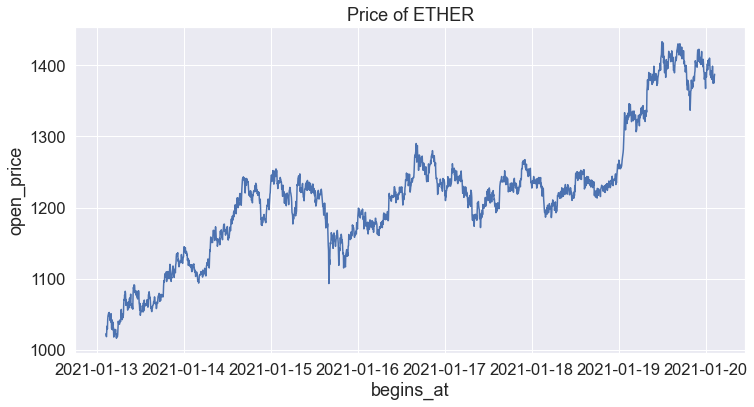

In [208]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="open_price", data=df).set_title("Price of ETHER")

It was in a long time silence following a small peak through the end 2013. Then reached its highest values at the end of 2017. We can make the graph look smoother by applying down-sampling.

In [209]:
# df.resample('.01D').mean().plot(figsize=(12,6))
# plt.figtext(.5,0.9,"Down-sampled to 10-day periods", fontsize=20, ha='center')

# Model

Long short-term memory (LSTM) is a type of recurrent neural network (RNN) and powerful to model sequence data because it maintains an internal state to keep track of the data it has already seen. Common applications of LSTMs include time series analysis and natural language processing.

LSTM requires the input to be a 3D tensor with shape (batch_size, timesteps, input_dim).

Batch_size: 
Timesteps:
input_dim:

I will build a model that predicts the value of litecoin at time t using the past 90 values (from t-90 to t-1). Therefore the the number of timesteps is 90. I only use "open" price to make the prediction so the input_dim is 1. The target variable is "open" price of litecoin which can be effected by many other factors. For example, the value of another crptocurrency may have an effect on litecoin. If we also use a second variable to make the prediction, than the input_dim will be 2.

## Data Preprocessing

I will re-organize the data in a way that a sequence of the values in previous 90 days is used to predict the value at time t. It is also better to normalize the values due to excessive computations done in a neural network.

In [210]:
data = df.iloc[:, 0]

In [211]:
hist = []
target = []
length = 90

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [212]:
print(len(hist[0]))
print(len(hist))
print(len(target))

90
1926
1926


In [213]:
print(hist[0][89])
print(data[89])

1056.87
1056.87


The last timestep of the first element is same as the 90th timestep of the original data which is what we planned to do.

The second element of hist should be just one timestep shifted version of first element. Therefore, the last timestep in the second element should be equal to the first item of the target variable which is the 91st timestep in the original data.

Let's double check to confirm:

In [214]:
print(hist[1][89])
print(data[90])
print(target[0])

1077.995
1077.995
1077.995


In [215]:
print(type(hist), type(target))

<class 'list'> <class 'list'>


In [216]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [217]:
print(type(hist), type(target))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [218]:
hist.shape

(1926, 90)

In [219]:
target.shape

(1926,)

In [220]:
target = target.reshape(-1,1)
target.shape

(1926, 1)

In [221]:
#Normalize the values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [222]:
#Reshape the input
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1926, 90, 1)


## Training and test sets

Our dataset includes 1951 samples (days). A sample of input consists of the value of litecoin for 90 consecutive days and target variable is the value of litecoin on the following day after the 90-day period.

I will split the dataset in a way that 1900 samples are used for training and then the model will be used to predict the trend in the following 51 days


In [223]:
X_train = hist_scaled[:1920,:,:]
X_test = hist_scaled[1920:,:,:]

y_train = target_scaled[:1920,:]
y_test = target_scaled[1920:,:]

## Building the neural network

In [224]:
import tensorflow as tf

from tensorflow.keras import layers, optimizers

In [225]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=32, dropout=0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 90, 32)            4352      
_________________________________________________________________
lstm_19 (LSTM)               (None, 90, 32)            8320      
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


We have created a model with 3 LSTM layers and 1 dense layer. It is time to compile and train the model.

In [226]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=50,
    decay_rate=0.9)
optimizer = optimizers.Adam(learning_rate=.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [227]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/4
60/60 [==============================] - 8s 55ms/step - loss: 0.2172
Epoch 2/4
60/60 [==============================] - 3s 55ms/step - loss: 0.2056
Epoch 3/4
60/60 [==============================] - 3s 55ms/step - loss: 0.2059
Epoch 4/4
60/60 [==============================] - 3s 56ms/step - loss: 0.1988


It seems like the model is converged in 30 epochs so there is no need to do additional epochs. The loss is less than 0.002 which I think is pretty good. 

Let's visualize how loss changes as number of epochs increases.

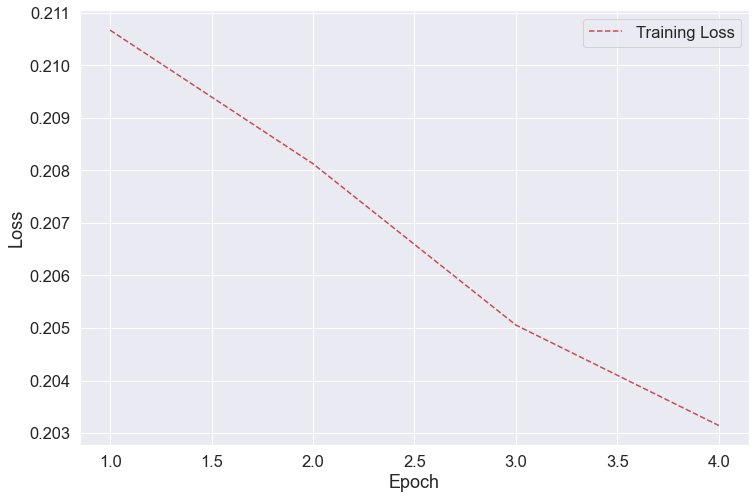

In [228]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

It seems like the model has converged after 15 epochs. After that, the loss is bouncing up and down around 0.0018.

Now it is time to make predictions.

In [229]:
pred = model.predict(X_test)

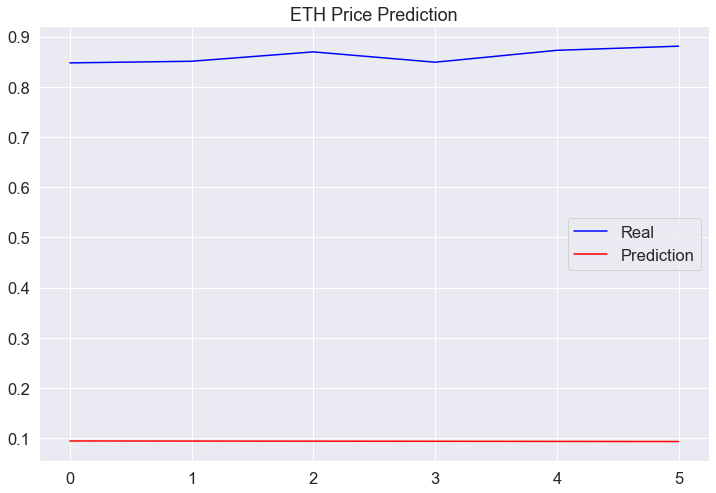

In [230]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('ETH Price Prediction')
plt.legend()
plt.show()

Our model achieved to determine the trend pretty well. As you may have noticed, the values are much less than the original values because we normalized the values before training the model. We can inverse transform to reflect the real prices but trend will be the same.

In [231]:
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)

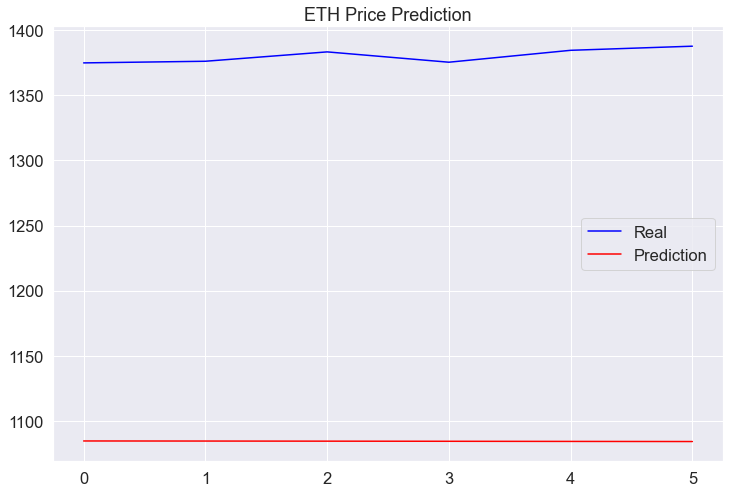

In [232]:
plt.figure(figsize=(12,8))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('ETH Price Prediction')
plt.legend()
plt.show()

There is always space for improvement. The fuel of a neural network is data so we can build a more robust and accurate model by collecting more data. We can also try to adjust number of nodes in a layer or add additional LSTM layers. We can also try to increase the number of timesteps which was 90 in our model. Another way to improve is to adjust parameters using GridSearchCV. 

Please keep in mind that it is not always good to increase the model accuracy because we may end up having an overfit model.

In [233]:
good = 0
bad = 0
i = 1
while(i < len(y_test_transformed)-1):
    if (y_test_transformed[i] < y_test_transformed[i+1]) and (pred_transformed[i] < pred_transformed[i+1]):
        # we're going up
        good = good + 1
    elif (y_test_transformed[i] > y_test_transformed[i+1]) and (pred_transformed[i] > pred_transformed[i+1]):
        good = good + 1
    else:
        bad = bad +1
    i = i + 1
print(good)
print(bad)
print(good/(good+bad))


1
3
0.25
